# EfficientNetB0 Transfer Learning for Astronomical Image Classification

This notebook uses EfficientNetB0 with transfer learning to classify deep space images into three categories: **galaxies**, **nebulae**, and **star clusters**. It works with a small, labeled dataset of Deep Space Objescts.


## 2. Import Required Libraries

We import TensorFlow, Keras components for image preprocessing, the EfficientNetB0 model, and some basic utilities.


In [ ]:
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import layers, models
from google.colab.output import eval_js
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.utils.class_weight import compute_class_weight



import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

# 2. Dataset

In this section, we will load our deep space objects dataset. It includes images from galaxies, nebulae, and star clusters. We will pull it from Google Drive, then split it into train, validation, and test sets. We will also apply basic preprocessing such as input resizing, normalization, etc.

## 2.1 Google Drive mounting


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## 2.2 Dataset generators and preprocessing

We define a base path for the dataset and apply data augmentation only on the training set. The `preprocess_input` function standardizes input images for EfficientNetB0. This setup preserves astronomical structure while making the model robust to minor variations.


In [ ]:
base_dir = '/content/drive/MyDrive/Transfer Learning in Astronomy/ODATA_FINAL'

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)


test_val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = test_val_datagen.flow_from_directory(
    os.path.join(base_dir, 'validation'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_val_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

print("Class indices:", train_generator.class_indices)

Found 1251 images belonging to 4 classes.
Found 311 images belonging to 4 classes.
Found 389 images belonging to 4 classes.
Class indices: {'clusters': 0, 'galaxies': 1, 'nebulae': 2, 'other': 3}


# 3. Import EfficientNetB0 and Build the Classifier

## 3.1 Load and Inspect the EfficientNetB0 Architecture

In [ ]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 4,007,548 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
# for layer in model.get_layer("efficientnetb0").layers:
#     print(layer.name)

## 3.2 Freeze the Pre-Trained Layers

Freezing the layers ensures that the pre-trained feature extraction remains intact during initial training.

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

## 3.3 Build a New Classifier on Top

In [ ]:
inputs = Input(shape=(224, 224, 3), name='input_image')
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
x = layers.Dense(256, activation='relu', name='dense')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(train_generator.num_classes, activation='softmax', name='classifier')(x)

model = models.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avg_pool                        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (Dense)              │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,378,535 (16.70 MB)

 Trainable params: 328,964 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

# 4. Training

## 4.1. TensorBoard setup

In [ ]:
log_dir = "/content/drive/MyDrive/Transfer Learning in Astronomy/EfficientNET/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# !nohup tensorboard --logdir "/content/drive/MyDrive/Transfer\ Learning\ in\ Astronomy/EfficientNET/logs" --host 0.0.0.0 --port 6006 &

## 4.2 Launch TensorBoard

In [ ]:
%load_ext tensorboard
# %reload_ext tensorboard

## 4.3. Train the model

Using `checkpoint` will automatically save the model during training — we can resume training from the latest checkpoint

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

earlystop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Transfer Learning in Astronomy/bestEfficientNet.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[checkpoint,tensorboard_callback]
)




/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6352 - loss: 0.8757
Epoch 1: val_loss improved from inf to 0.42308, saving model to /content/drive/MyDrive/Transfer Learning in Astronomy/bestEfficientNet.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 454s 11s/step - accuracy: 0.6381 - loss: 0.8699 - val_accuracy: 0.8842 - val_loss: 0.4231
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8731 - loss: 0.3380
Epoch 2: val_loss improved from 0.42308 to 0.31563, saving model to /content/drive/MyDrive/Transfer Learning in Astronomy/bestEfficientNet.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.8735 - loss: 0.3376 - val_accuracy: 0.9068 - val_loss: 0.3156
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8796 - loss: 0.2894
Epoch 3: val_loss improved from 0.31563 to 0.29733, saving model to /content/drive/MyDrive/Transfer Learning in Astronomy/bestEfficientNet.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 160s 4s/step - accuracy: 0.8797 - loss: 0.2895 - val_accurac

In [ ]:
#start tensorboard
%tensorboard --logdir "/content/drive/MyDrive/Transfer Learning in Astronomy/EfficientNET/logs/fit/"

## 4.4 Fine-Tuning the last layers for OOD detection.

Unfreezing the top 20–30 layers lets the model adapt its feature extractor (not just the classifier head) to better learn what actually makes something a galaxy, a nebula or a cluster.

It can cause it to become less confident on **OOD** (out-of-distribution) images — now, the feature representations will better separate DSOs from everything else, even without explicit negatives. This enables us to later use a threshold for distinguishing DSO from non-DSO images.

In [ ]:
base_model = model.get_layer("efficientnetb0")
base_model.trainable = True

fine_tune_at = len(base_model.layers) - 30
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/Transfer Learning in Astronomy/fine_tuned_efficientnet.keras',
        save_best_only=True
    )
]

history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=callbacks
)


Epoch 1/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 151s 3s/step - accuracy: 0.9653 - loss: 0.1010 - val_accuracy: 0.9582 - val_loss: 0.1384
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 150s 4s/step - accuracy: 0.9728 - loss: 0.0950 - val_accuracy: 0.9582 - val_loss: 0.1349
Epoch 3/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - accuracy: 0.9561 - loss: 0.1167 - val_accuracy: 0.9582 - val_loss: 0.1340
Epoch 4/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 132s 3s/step - accuracy: 0.9729 - loss: 0.0944 - val_accuracy: 0.9582 - val_loss: 0.1334
Epoch 5/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 131s 3s/step - accuracy: 0.9633 - loss: 0.1068 - val_accuracy: 0.9582 - val_loss: 0.1324


# 5. Evaluate and Visualize the Model Performance

## 5.1 Plot Training Metrics

Plot training and validation accuracy to observe how well the model is learning and generalizing.


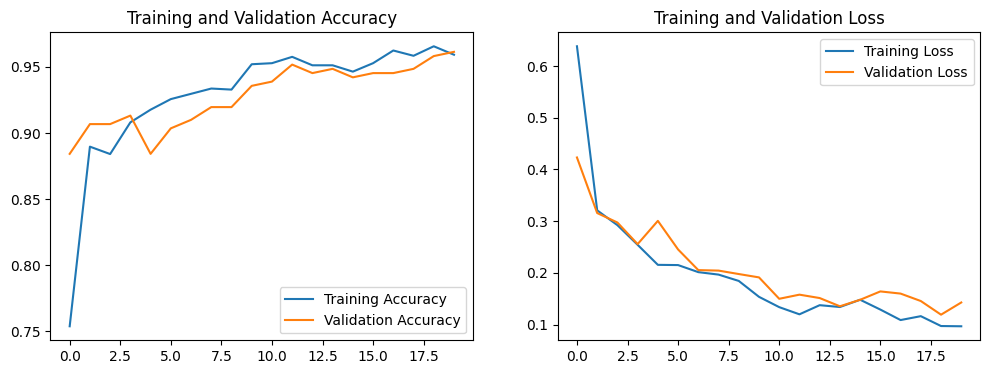

13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step


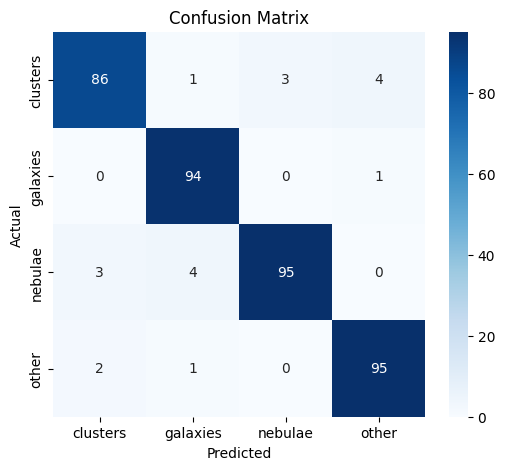

Classification Report:
              precision    recall  f1-score   support

    clusters       0.95      0.91      0.93        94
    galaxies       0.94      0.99      0.96        95
     nebulae       0.97      0.93      0.95       102
       other       0.95      0.97      0.96        98

    accuracy                           0.95       389
   macro avg       0.95      0.95      0.95       389
weighted avg       0.95      0.95      0.95       389



In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


## 5.2 Final Evaluation on the Test Set

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.9342 - loss: 0.1723
Test Loss: 0.14155828952789307
Test Accuracy: 0.9511567950248718


# 6. Predict a Specific Image

In [ ]:
img_path = '/content/drive/MyDrive/Transfer Learning in Astronomy/comet_10.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

predictions = model.predict(x)[0]
predicted_class_index = np.argmax(predictions)

predicted_probability = predictions[predicted_class_index] * 100

class_indices = train_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

predicted_class_name = idx_to_class[predicted_class_index]
print(f"Predicted Class: {predicted_class_name} ({predicted_probability:.2f}%)")

for class_idx, class_prob in enumerate(predictions):
    class_name = idx_to_class[class_idx]
    print(f"{class_name}: {class_prob:.2%}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Class: other (98.46%)
clusters: 0.00%
galaxies: 1.51%
nebulae: 0.03%
other: 98.46%


# 7. Save the model

In [ ]:
model_save_path = '/content/drive/MyDrive/Transfer Learning in Astronomy/Models/efficientnet-4c-20ep-ft.keras'
model.save(model_save_path)

print(f"Model saved successfully at: {model_save_path}")


Model saved successfully at: /content/drive/MyDrive/Transfer Learning in Astronomy/Models/efficientnet-4c-20ep-ft.keras


# *8. Load the model

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Transfer Learning in Astronomy/Models/efficientnet-v4-ft-57.keras')


# * Embeddings (Optional, needed for app OOD inference)

In [ ]:
import numpy as np
import os
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tqdm import tqdm
import tensorflow as tf

def save_embeddings(model, dataset_dir, embedding_layer_name, model_name, output_drive_path):
    embedding_model = Model(inputs=model.input, outputs=model.get_layer(embedding_layer_name).output)

    embeddings = []
    filenames = []

    for root, dirs, files in os.walk(dataset_dir):
        for fname in tqdm(files, desc=f"Processing"):
            fpath = os.path.join(root, fname)
            try:
                img = image.load_img(fpath, target_size=(224, 224))
                img_array = image.img_to_array(img)
                img_array = tf.keras.applications.imagenet_utils.preprocess_input(img_array)
                img_array = np.expand_dims(img_array, axis=0)

                emb = embedding_model.predict(img_array, verbose=0)
                embeddings.append(emb.flatten())
                relative_path = os.path.relpath(fpath, dataset_dir)
                filenames.append(relative_path)
            except Exception as e:
                print(f"Skipping {fname}: {e}")

    embeddings = np.array(embeddings)

    save_path = os.path.join(output_drive_path, f"{model_name}_embeddings.npz")
    np.savez_compressed(save_path, embeddings=embeddings, filenames=filenames)
    print(f"Saved {len(embeddings)} embeddings to {save_path}")


In [ ]:
dataset_dir = '/content/drive/MyDrive/Transfer Learning in Astronomy/ODATA_FINAL'
output_drive_path = '/content/drive/MyDrive/Transfer Learning in Astronomy/Embeddings'
os.makedirs(output_drive_path, exist_ok=True)
embedding_layer_name = 'dense'
model_name = 'efficientnet'

save_embeddings(model, dataset_dir, embedding_layer_name, model_name, output_drive_path)

Processing: 0it [00:00, ?it/s]
Processing: 0it [00:00, ?it/s]
Processing: 100%|██████████| 79/79 [00:07<00:00, 10.84it/s]
Processing: 0it [00:00, ?it/s]
Processing: 100%|██████████| 95/95 [00:07<00:00, 12.82it/s]
Processing: 0it [00:00, ?it/s]
Processing: 100%|██████████| 327/327 [00:29<00:00, 11.08it/s]


Saved 1951 embeddings to /content/drive/MyDrive/Transfer Learning in Astronomy/Embeddings/efficientnet_embeddings.npz


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


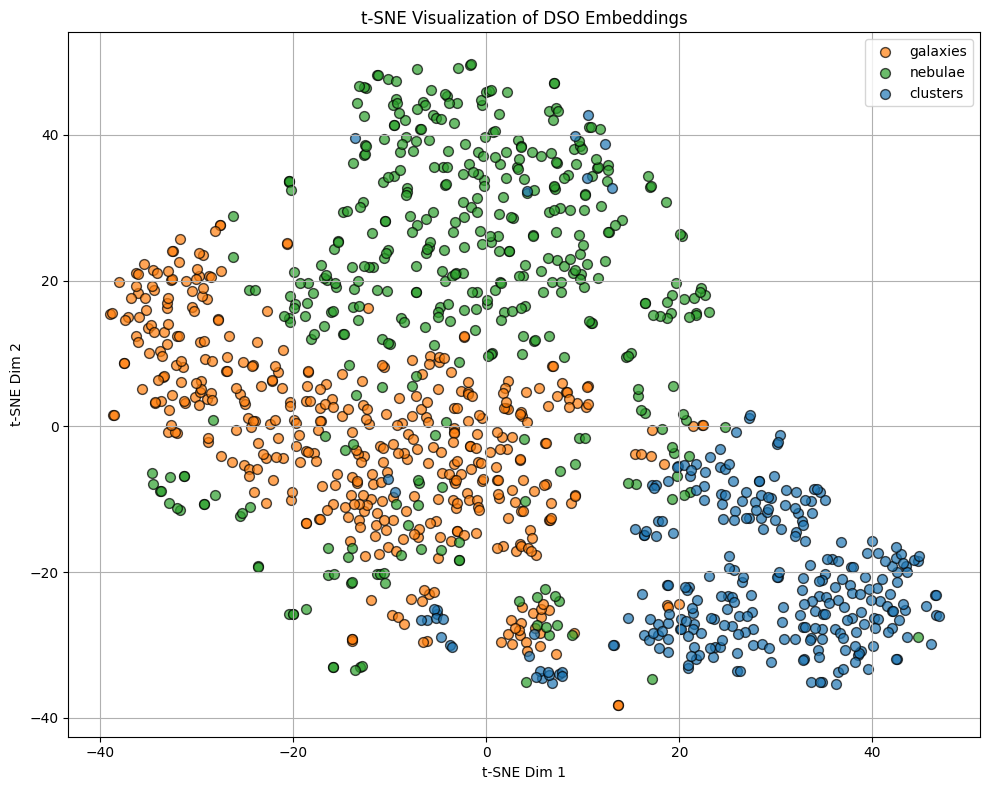

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_results = tsne.fit_transform(ref_embeddings)

plt.figure(figsize=(10, 8))
unique_labels = sorted(set(ref_labels))
colors = plt.cm.tab10(range(len(unique_labels)))
label_to_color = {label: colors[i] for i, label in enumerate(unique_labels)}

for i, label in enumerate(ref_labels):
    plt.scatter(tsne_results[i, 0], tsne_results[i, 1],
                color=label_to_color[label],
                label=label if label not in ref_labels[:i] else "",
                s=50, alpha=0.7, edgecolors='k')

plt.title("t-SNE Visualization of DSO Embeddings")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
